## load packages

In [1]:
import google.datalab.storage as storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from google.datalab import Context
import random, string

p = sns.color_palette()

## load data

In [2]:
my_bucket = storage.Bucket('capstone-02/data')

events = my_bucket.object('events.csv')
uri = events.uri
%gcs read --object $uri --variable c_test
events = pd.read_csv(BytesIO(c_test))
events.head(5)

/usr/local/envs/py2env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


## preprocess "platform"

platform의 value가 두 가지 타입(int, str)으로 나누어져 있으므로 통일시켜주는 전처리를 시행한다<br>
str value를 int로 바꿔주고, missing value 5개는 삭제한다

In [50]:
events.platform.unique()

array([3, 2, 1, '2', '1', '3', '\\N'], dtype=object)

In [51]:
events.loc[events['platform']=='1','platform'] = 1
events.loc[events['platform']=='2','platform'] = 2
events.loc[events['platform']=='3','platform'] = 3

In [52]:
events.shape

(23120126, 6)

In [54]:
events = events[events['platform'] != '\\N']
events.shape

(23120121, 6)

## get uniques

events.csv의 6개 컬럼별 unique 개수를 구한다

In [55]:
print(events['display_id'].unique().shape)
print(events['uuid'].unique().shape)
print(events['document_id'].unique().shape)
print(events['timestamp'].unique().shape)
print(events['platform'].unique().shape)
print(events['geo_location'].unique().shape)

(23120121,)
(19794962,)
(894060,)
(22896617,)
(3,)
(2989,)


## uuid

uuid는 user unique id, 즉 유저를 말한다<br>
사용자(uuid)별 display 노출 횟수를 알아본다

uuid
45d23867dbe3b3    38
ef7761dd22277c    38
c0bd502c7a479f    42
2759b057797f02    46
b88553e3a2aa29    49
Name: uuid, dtype: int64
Users that appear less than 2 times: 88.42%
Users that appear less than 5 times: 99.51%
Users that appear less than 10 times: 99.96%


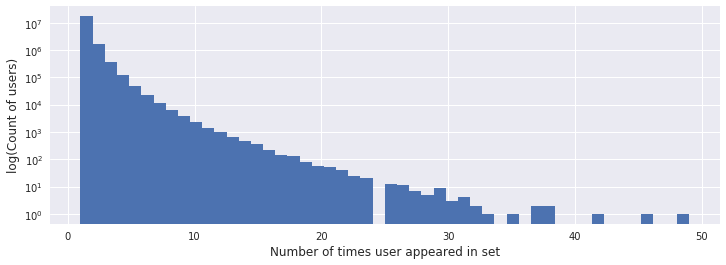

In [63]:
# 사용자(uuid)별 display 노출 횟수 확인
uuid_counts = events.groupby('uuid')['uuid'].count().sort_values()
print(uuid_counts.tail())

for i in [2, 5, 10]:
    print('Users that appear less than {} times: {}%'.format(i, round((uuid_counts<i).mean() * 100, 2)))
    
# 시각화
plt.figure(figsize=(12,4))
plt.hist(uuid_counts.values, bins=50, log=True)
plt.xlabel('Number of times user appeared in set', fontsize=12)
plt.ylabel('log(Count of users)', fontsize=12)
plt.show()

## document_id

document_id는 유저가 방문한 방문페이지를 말한다<br>
방문페이지 안에 display가 노출되고, display 안에 ad가 노출된다<br>
방문페이지(document_id) 등장 횟수를 알아본다

docs that appear less than 2 times: 35.72%
docs that appear less than 5 times: 64.52%
docs that appear less than 10 times: 77.81%
docs that appear less than 100 times: 96.44%
docs that appear less than 1000 times: 99.7%


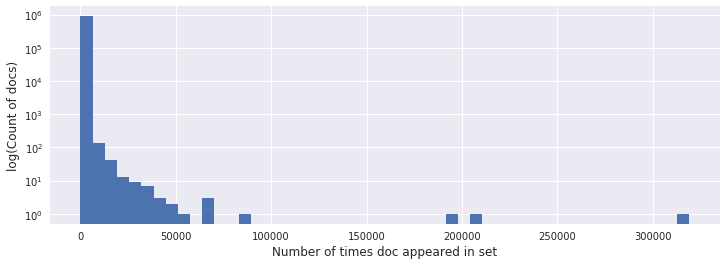

In [104]:
# 방문페이지(document_id) 등장 횟수 확인
doc_counts = events.groupby('document_id')['document_id'].count().sort_values()
doc_counts.tail(5)

for i in [2, 5, 10, 100, 1000]:
    print('docs that appear less than {} times: {}%'.format(i, round((doc_counts<i).mean() * 100, 2)))
    
# 시각화
plt.figure(figsize=(12,4))
plt.hist(doc_counts.values, bins=50, log=True)
plt.xlabel('Number of times doc appeared in set', fontsize=12)
plt.ylabel('log(Count of docs)', fontsize=12)
plt.show()

## platforms

platform은 사용자 접속 기기를 말한다<br>
platform은 총 3개의 level을 가진 categorical 변수이며, level별 설명은 다음과 같다<br>
1=desktop, 2=mobile, 3=tablet

In [56]:
# 접속 기기(platform)별 display 개수 확인
plat = events.platform.value_counts()
print(plat)
print('\nUnique values of platform:', events.platform.unique())

2    10976278
1     9027268
3     3116575
Name: platform, dtype: int64
('\nUnique values of platform:', array([3, 2, 1], dtype=object))


Text(0,0.5,u'Occurence count')

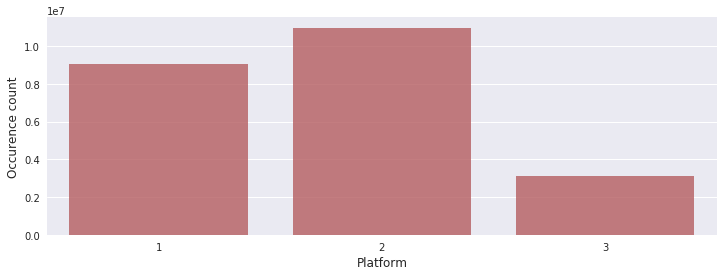

In [59]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

# 시각화
plt.figure(figsize=(12,4))
sns.barplot(plat.index, plat.values, alpha=0.8, color=p[2])
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Occurence count', fontsize=12)

## timestamp

timestamp는 광고 클릭이 발생한 시간이다<br>
2016년 6월 14일 오전 4시부터 6월 29일 오전 4시까지의 데이터셋이다<br>
<br>
events first timestamp : 2016-06-14 04:00:00.059<br>
events final timestamp : 2016-06-29 03:59:59.803

In [4]:
# timestamp 전처리를 통해 datetime 형태로 만들기
events.loc[:, 'timestamp'] = [i + 1465876799998 for i in events.loc[:, 'timestamp']]
events.loc[:, 'timestamp'] = pd.to_datetime(events.loc[:, 'timestamp'], unit='ms')

In [78]:
events_time = events.sort_values(by=['timestamp'], axis=0, ascending=False)
events_time.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
23120125,23120126,b545c100626cba,2357447,2016-06-29 03:59:59.803,2,US>SD>764
23120124,23120125,6bbdc5756789cc,744496,2016-06-29 03:59:59.769,2,US>MI>505
23120123,23120124,11f9ac8cee26f2,751048,2016-06-29 03:59:59.655,2,US>GA>524
23120122,23120123,7efccdc2d58fd1,2984543,2016-06-29 03:59:59.589,2,US>TX>623
23120121,23120122,3b42aaa4aa8993,1827718,2016-06-29 03:59:59.572,1,US>FL>571


In [79]:
events_time.tail()

,display_id,uuid,document_id,timestamp,platform,geo_location
4,5,8d0daef4bf5b56,252458,2016-06-14 04:00:00.336,2,SG>00
3,4,85281d0a49f7ac,1777797,2016-06-14 04:00:00.232,2,US>WV>564
2,3,822932ce3d8757,1179111,2016-06-14 04:00:00.180,2,US>MI>505
1,2,79a85fa78311b9,1794259,2016-06-14 04:00:00.079,2,US>CA>807
0,1,cb8c55702adb93,379743,2016-06-14 04:00:00.059,3,US>SC>519


## geo_location

geo_location은 유저가 광고를 클릭할 때, 유저가 있는 지역 정보를 말한다<br>
geo_location은 국가>주>DMA\*로 구성되어 있다<br>
\*DMA: 미국 Nielsen DMA(지정 시장 지역)

In [3]:
events_geo = events.geo_location.str[:2]
events_geo_unq = events_geo.unique()
events_geo_unq.shape
# unique 국가 개수는 231개다

(231,)

In [6]:
events_us = events[events.geo_location.str[:2] == 'US']
events_us.head(10)

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,2016-06-14 04:00:00.059,3,US>SC>519
1,2,79a85fa78311b9,1794259,2016-06-14 04:00:00.079,2,US>CA>807
2,3,822932ce3d8757,1179111,2016-06-14 04:00:00.180,2,US>MI>505
3,4,85281d0a49f7ac,1777797,2016-06-14 04:00:00.232,2,US>WV>564
5,6,7765b4faae4ad4,1773517,2016-06-14 04:00:00.393,3,US>OH>510
6,7,2cc3f6457d16da,1149661,2016-06-14 04:00:00.600,2,US>MT>762
7,8,166fc654d73c98,1330329,2016-06-14 04:00:00.636,2,US>PA>566
8,9,9dddccf70f6067,1772126,2016-06-14 04:00:00.665,1,US>FL>528
9,10,b09a0e92aa4d17,157455,2016-06-14 04:00:00.691,1,US
10,11,602e210c5831e5,1773230,2016-06-14 04:00:00.708,3,US>IL>675


In [7]:
print(len(events_us))
print(float(18595447)/float(23120126))
# 클릭이 발생한 국가가 US인 행의 개수는 18595447다
# US가 전체 데이터의 80%를 차지한다

18595452
0.804296957551


In [9]:
events_ca = events[events.geo_location.str[:2] == 'CA']
events_ca.head(10)

,display_id,uuid,document_id,timestamp,platform,geo_location
33,34,50f4b6d1ca43da,455604,2016-06-14 04:00:02.618,3,CA>NB
46,47,aa2c669077aba3,1778648,2016-06-14 04:00:03.387,1,CA>SK
55,56,7f9b8ead7a7162,1108855,2016-06-14 04:00:03.923,2,CA>ON
66,67,cdce8c4d4f9434,1778533,2016-06-14 04:00:05.271,1,CA>ON
89,90,7d1fd1378662bc,1750826,2016-06-14 04:00:06.351,3,CA>ON
96,97,e065fb1ce7c70d,1749540,2016-06-14 04:00:07.132,1,CA>SK
100,101,3abf1630ff91c5,1029942,2016-06-14 04:00:07.394,1,CA>BC
114,115,2e0409d4a989f6,1789106,2016-06-14 04:00:08.646,1,CA>ON
130,131,3486a29c27bf99,1574486,2016-06-14 04:00:09.942,1,CA>QC
136,137,9e50684b9997b8,1670317,2016-06-14 04:00:10.470,1,CA>ON


In [10]:
print(len(events_ca)) # 1215350
print(float(18595447+1215350)/float(23120126))
# 클릭이 발생한 국가가 CA인 행의 개수는 1215350다
# US, CA가 전체 데이터의 85.7%를 차지한다

1215350
0.856863712594


In [103]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# state 별 데이터 개수 카운트
usa = events_us.loc[events_us.geo_location.str[:2]=='US', :]
usa = usa[["uuid", "geo_location"]]
usa.columns = ['uuid', 'State']
usa.State = usa.State.str[3:5]
usa = usa.loc[usa.State != '', :]
usa.loc[:, 'UserCount'] = usa.groupby('State')['State'].transform('count')
usa.loc[:, ['State', 'UserCount']] = usa.loc[:, ['State', 'UserCount']].drop_duplicates('State', keep='first')
usa.sort_values('UserCount', ascending=False, inplace=True)

# state 코드와 매칭, StateName 열 생성
stateCode2Name = {'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN':'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE':'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming'}
usa['StateName'] = usa['State'].map(stateCode2Name)
usa.dropna(inplace=True)

# state 별 누적퍼센트 계산
usa['CumulativePercentage'] = 100 * usa.UserCount.cumsum()/usa.UserCount.sum()
usa.reset_index(drop=True, inplace=True)
usa[['StateName', 'UserCount', 'CumulativePercentage']].head(50)

,StateName,UserCount,CumulativePercentage
0,California,2395278.0,13.436491
1,Texas,1645323.0,22.666054
2,Florida,1128279.0,28.995219
3,New York,1105925.0,35.198988
4,Pennsylvania,784612.0,39.600328
5,Illinois,745661.0,43.783169
6,Ohio,633699.0,47.337951
7,Michigan,623564.0,50.835880
8,North Carolina,597003.0,54.184813
9,New Jersey,537440.0,57.199623
